# Expanding the Capabilities of SDO: SDO/AIA Autocalibration
In this notebook, we demonstrate the SDO Autocalibration model, as described in [Dos Santos et al., 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...648A..53D/abstract)

Luiz F. G. dos Santos, Souvik Bose, Valentina Salvatelli, Brad Neuberg, Mark C. M. Cheung, Miho Janvier, Meng Jin, Yarin Gal, Paul Boerner, Atılım Güneş Baydin

---

## Introduction

Since it launch in 2010, the Solar Dynamics Observatory (SDO) has continually monitored the dynamic Sun. SDO observes over a range of wavelengths including the Extreme ultraviolet (EUV), which allows us to probe the dynamics of the outermost layers of the Sun: the chromosphere and corona

Unfortunately, EUV imagers suffer from time-dependent degradation of the EUV filters. This reduces their sensitivity, and is observed as an apparent decrease in total flux as a function of time. For SDO, sounding rocket flights have been used to periodically calibrate the Atmospheric Imaging Assembly (AIA). The time-dependent degradation curves for AIA are then derived by interpolated between subsequent flights. 

In this notebook we perform inference on the convolutional neural network model by [Dos Santos et al., 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...648A..53D/abstract), to first extract the degradation curves, and then correct a set of images over 10 years of observation.

**N.B:** *The main dataset used for the project is the SDO ML dataset (see [Galvez et al., 2019](https://ui.adsabs.harvard.edu/abs/2019ApJS..242....7G/abstract)). For this notebook, we utilize a dataset that is not corrected for degradation, and is available from [Zenodo](https://zenodo.org/record/4430801#.X_xiP-lKhmE).*

---

## Table of Contents

The notebook is set out as follows:

1. Setting up the notebook
2. Reading and loading the SDO/AIA data
3. Autocalibration Inference <br>
    3a. Multi-channel Model <br>
3. Plotting the degradation curves
4. Downloading & Correcting AIA images
5. Discussion

## 1. Setting up the notebook


In [3]:
# first install sunpy as it's not included here
!pip install sunpy[all]

In [5]:
# now we will git clone the autocal repo, and install the package:
!git clone https://github.com/vale-salvatelli/sdo-autocal_pub
!pip install -e sdo-autocal_pub/.

fatal: destination path 'sdo-autocal_pub' already exists and is not an empty directory.
Obtaining file:///content/sdo-autocal_pub
  Found existing installation: sdo 0.2a0.post0.dev4+g0ff2f50
    Can't uninstall 'sdo'. No files were found to uninstall.
  Running setup.py develop for sdo


In [6]:
import datetime
import math

import torch
import astropy.time
import sunpy.map

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import units as u

from sdo.datasets.degradation_sdo_dataset import DegradationSDO_Dataset
from sdo.pytorch_utilities import create_dataloader
from sdo.models.autocalibration_models import Autocalibration6, Autocalibration10
from astropy.visualization import time_support
from scipy.stats import ks_2samp
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch, time_support
from sunpy.net import Fido, attrs

⚠️ if you get an error importing `sdo`, try restarting the runtime ⚠️

In [ ]:
data_basedir = '/media/paul/data/autocal_npz/data_small/'
data_inventory = '/media/paul/data/autocal_npz/small_inventory.pkl'
results_path = '/media/paul/data/autocal_npz/results/'

instr = ['AIA']*7
channels = ['0094','0131','0171','0193','0211','0304','0335']
channels_names = ['$94~\AA$','$131~\AA$','$171~\AA$','$193~\AA$','$211~\AA$','$304~\AA$','$335~\AA$']

## 2. Reading and loading the SDO/AIA data

In [ ]:
model_file = '/media/paul/data/autocal_npz/Models/luiz_exp_36_apodize_model.pth'

In [ ]:
test_dataset = DegradationSDO_Dataset(data_basedir = data_basedir,
                                    data_inventory = data_inventory,
                                    instr = instr,
                                    channels = channels,
                                    yr_range = [2010,2020],
                                    mnt_step = 1,
                                    day_step = 7,
                                    h_step = 1,
                                    min_step = 1,
                                    resolution = 512,
                                    subsample = 2,
                                    normalization = 0, 
                                    scaling = True,
                                    apodize = True,
                                    shuffle = False,
                                    holdout = False,
                                    test = True,
                                    test_ratio = 1)

test_loader = create_dataloader(test_dataset, batch_size=24, num_dataloader_workers=4, shuffle=False, train=False)

Loading in the model:

In [ ]:
# this step could potentially take a while

model = Autocalibration6(input_shape=[7, 256, 256], output_dim=7)
model.load_state_dict(torch.load(model_file,map_location=torch.device('cuda'))) # need to use cuda if available.

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## 3. Autocalibration Inference

In [Dos Santos et al., 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...648A..53D/abstract), two models were tested: a multi-channel model, and a single-channel model...

### 3a. Multi-channel Model

In [ ]:
final_predictions = []
with torch.no_grad():
    for batch_idx, (input_data, dates) in enumerate(test_loader):
        if batch_idx==0:
            output = model(input_data)
            temp_degradation_multi = output
            dates_multi_channel_array = np.array(dates)
        else:
            output = model(input_data)
            temp_degradation_multi = torch.cat((temp_degradation_multi, output), 0)
            dates_multi_channel_array = np.append(dates_multi_channel_array,dates,axis=0) 

degradation_multi_channel = temp_degradation_multi.detach().numpy()

#### Converting all times to astropy time.

In [ ]:
eve_date = ['20140526','20140526'] #Last date with EVE MEGS-A data.
last_training_date = ['20131231','20131231'] #Last date with EVE MEGS-A data.
xticks = ['20100101','20110101','20120101','20130101','20140101','20150101','20160101','20170101','20180101','20190101','20200101',]

dates_multi_channel_str = list(map('{:4d}{:02d}{:02d}{:02d}{:02d}'.format,dates_multi_channel_array[:,0],dates_multi_channel_array[:,1],dates_multi_channel_array[:,2],dates_multi_channel_array[:,3],dates_multi_channel_array[:,4]))

dates_multi = [datetime.datetime.strptime(i,"%Y%m%d%H%M").date() for i in dates_multi_channel_str]
dates_multi = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in dates_multi])

eve_line = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in eve_date]
eve_line = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in eve_line])

last_training_line = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in last_training_date]
last_training_line = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in last_training_line])

xticks = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in xticks]
xticks = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in xticks])

dates_single=[]
for c in range(len(channels)):
    dates_single_channel_str = list(map('{:4d}{:02d}{:02d}'.format,dates_single_channel_array[c][:,0],dates_single_channel_array[c][:,1],dates_single_channel_array[c][:,2]))
    temp = [datetime.datetime.strptime(i,"%Y%m%d").date() for i in dates_single_channel_str] #x_values for 0094
    temp = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in temp])
    dates_single.append(temp)

#### Defining two fuctions to use as a median filter

In [ ]:
def date_median(dates):
    median = math.floor(np.median(dates.astype('int64')))
    result = np.datetime64(median, "ns") #unit: nanosecond
    return result

def moving_median(data,dates,window):
    iti = int(np.floor(data.shape[0]/window))
    median = []
    date = []
    
    for i in range(iti-1):
        median.append(np.median(data[(i*window):((i+1)*window)]))
        date.append(date_median(dates[(i*window):((i+1)*window)]))
        
    return np.array(median, dtype='float64'), pd.to_datetime(date)

def moving_std(data,dates,window):
    iti = int(np.floor(data.shape[0]/window))
    std = []    

    for i in range(iti):
        std.append(np.std(data[(i*window):((i+1)*window)]))
                
    return np.array(std, dtype='float64')

---

## 4. Plotting the Degradation Curve

In [7]:
#v9dat = pd.read_csv('/media/paul/data/autocal_npz/data_v_ratios.csv', parse_dates=True,
#                    names=["DATE"] + channels, index_col="DATE",skiprows=1, header=0) #Reading the degradations obtained from AIApy for curve V9
v8dat = pd.read_csv('/media/paul/data/autocal_npz/data_v8table.csv', parse_dates=True,
                    names=["DATE"] + channels) #Reading the degradations obtained from AIApy for curve V8

v8dat['DATE'].replace('Z', '.000',regex=True,inplace=True) #Fixing some inconsistent data formating
v8dat['DATE'] = pd.to_datetime(v8dat['DATE'], infer_datetime_format=True)
v8dat.set_index('DATE', inplace=True)

time_support()  #Adding support of Astropy date to plot.
colors = ['Blue','Orange','Green','Red','Purple','Brown','Magenta']

fig, ax = plt.subplots(4, 2, figsize=(17/3,22/3), dpi=92)
fig.subplots_adjust(wspace=0.1,hspace=0.18)
ax = ax.ravel()    

for c in range(len(channels)):
    #v9dat[channels[c]] = v9dat[channels[c]].astype(np.float64)
    v8dat[channels[c]] = v8dat[channels[c]].astype(np.float64)

    #v9dat[channels[c]] = v9dat[channels[c]]/v9dat[channels[c]][0]
    v8dat[channels[c]] = v8dat[channels[c]]/v8dat[channels[c]][0]
    #v9med_data, v9med_dates = moving_median(v9dat[channels[c]],v9dat.index,28)
    v8med_data, v8med_dates = moving_median(v8dat[channels[c]],v8dat.index,28)

    multi_med_data, multi_med_dates = moving_median(degradation_multi_channel[:,c],pd.DataFrame(dates_multi.tt.datetime),15)
    multi_std_data = moving_std(degradation_multi_channel[:,c],pd.DataFrame(dates_multi.tt.datetime),15)
    
    #euv_v9_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in v9med_dates])
    euv_v8_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in v8med_dates])
    multi_med_times = astropy.time.Time([astropy.time.Time(i.isoformat()) for i in multi_med_dates])

    ax[c].fill_between(dates_multi[0:209],1.5,0,color=colors[c],label='Training data period', alpha=0.05)
    ax[c].plot(last_training_line,[0,2], '--', color='black', label='Last Training date')
    ax[c].plot(eve_line,[0,2], '--', color='gray', label='Last EVE MEGS-A data')
    ax[c].plot(multi_med_times, multi_med_data, \
               label=channels_names[c]+' - Multi-Channel',linewidth=2,color=colors[c])
    #ax[c].plot(euv_v9_times, v9med_data, color='black',\
    #           label=channels_names[c]+' - Degradation V9', linewidth=3, alpha=0.9)
    ax[c].plot(euv_v8_times, v8med_data, color='gray',\
               label=channels_names[c]+' - Degradation V8', linewidth=3, alpha=0.9)
    
    #up = [m + n for m, n in zip(v9med_data, v9med_data*0.28)]
    up_multi = [m + n for m,n in zip(multi_med_data,multi_std_data)]
    #down = [m - n for m, n in zip(v9med_data,v9med_data*0.28)]
    down_multi = [m - n for m,n in zip(multi_med_data,multi_std_data)]

    #ax[c].fill_between(euv_v9_times,up,down,color='gray', alpha=0.1)
    ax[c].fill_between(multi_med_times,up_multi,down_multi,color=colors[c], label='Standard Deviation', alpha=0.1)

    if c%2 == 0:
        ax[c].set_ylabel('Degradation',fontsize=14)
    
    ax[c].set_xlabel('Time (UTC)',fontsize=14)
    plt.xticks(np.arange(0,4),fontsize=14)
    plt.yticks(fontsize=14)
    ax[c].legend(fontsize=10)
    ax[c].set_ylim(0,1.05)
    ax[c].set_xlim(multi_med_times[0]-1,multi_med_times[-1])

ax[c+1].set_visible(False)

NameError: ignored

**Figure 2**: Channel degradation as a function of time. From top to bottom: Channel 94 Å (blue) and 131 Å (yellow), 171Å (green) and 193 Å (red), 211 Å (purple) and 304 Å (brown) and 335 Å (magenta). The solid black (gray) curve is the degradation profile of AIA calibration release V9 (V8). The gray shaded area corresponds to the 25% error of the degradation curve (V9). The colorful shaded areas are the standard deviation of the CNN models.The vertical black dashed line is the last available observation from EVE MEGS-A data and the vertical gray dashed line is the last training date.

## 5. Downloading & Correcting AIA images

### Generating the AIA Autocalibration correction table

In [ ]:
autocal_table = []

for i in range(0,len(dates_multi_channel_array)):
    d = {
        **{'DATE' : dates_multi.tt.datetime[i]},
        **{channels[n]: degradation_multi_channel[i][n] for n in range(len(degradation_multi_channel[i]))}
    }
    autocal_table.append(d)

autocal_table = pd.DataFrame(autocal_table)

Here, we will directly query Stanford's Joint Science Operations Crnter (JSOC). Alternatively, one could also use Fido, as part of SunPy, however, in testing, queries on such extreme time-sclaes resulted in varying levels of success:

```
files = []

query = Fido.search(
    attrs.Time(f'2010-08-01T00:00:00', f'2020-08-01T01:00:00'),
    attrs.Sample(30*u.min),
    attrs.Instrument('AIA'),
    attrs.Wavelength(304*u.angstrom),
)

dn =Fido.fetch(query[0][0])
files.append(dn[0])
    
maps = sunpy.map.Map(files)
```

In [ ]:
import drms
email = 'paul@wrightai.com'
c = drms.Client(debug=True, verbose=True, email=email)
r = c.export('aia.lev1_euv_12s[2010.06.01/3600d@365d][304]{image}', method='url', protocol='fits')
maps = sunpy.map.Map(sorted(r.urls['url']))

http://jsoc.stanford.edu/cgi-bin/ajax/checkAddress.sh?address=paul%2540wrightai.com&checkonly=1
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_info?op=series_struct&ds=aia.lev1_euv_12s
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_fetch?op=exp_request&format=json&ds=aia.lev1_euv_12s%5B2010.06.01%2F3600d%40365d%5D%5B304%5D%7Bimage%7D&notify=paul%40wrightai.com&method=url&protocol=fits&filenamefmt=aia.lev1_euv_12s.%7BT_REC%3AA%7D.%7BWAVELNTH%7D.%7Bsegment%7D&process%3Dn=0&requestor=paul
Export request pending. [id=JSOC_20210512_936, status=2]
Waiting for 5 seconds...
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_fetch?op=exp_status&requestid=JSOC_20210512_936
Export request pending. [id=JSOC_20210512_936, status=1]
Waiting for 5 seconds...
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_fetch?op=exp_status&requestid=JSOC_20210512_936
Export request pending. [id=JSOC_20210512_936, status=1]
Waiting for 5 seconds...
http://jsoc.stanford.edu/cgi-bin/ajax/jsoc_fetch?op=exp_status&requestid=JSOC_20210512_93

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2010-06-01T000010Z.304.image_lev1.fits:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2011-06-01T000010Z.304.image_lev1.fits:   0%|          | 0.00/9.48M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2012-05-31T000010Z.304.image_lev1.fits:   0%|          | 0.00/9.30M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2013-05-31T000009Z.304.image_lev1.fits:   0%|          | 0.00/9.13M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2014-05-31T000009Z.304.image_lev1.fits:   0%|          | 0.00/8.51M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2015-05-31T000009Z.304.image_lev1.fits:   0%|          | 0.00/7.87M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2016-05-30T000008Z.304.image_lev1.fits:   0%|          | 0.00/7.46M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2017-05-30T000007Z.304.image_lev1.fits:   0%|          | 0.00/7.23M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2018-05-30T000007Z.304.image_lev1.fits:   0%|          | 0.00/7.15M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia.lev1_euv_12s.2019-05-30T000007Z.304.image_lev1.fits:   0%|          | 0.00/7.15M [00:00<?, ?B/s]

Now that we have observations, we need to correct these for degradation. We will query the closest degradation value in the autocal table:

In [ ]:
def correct_degradation(smap, table):
    """
    Correct degradation using time-step in the correction table that is closest to the observation date.
    """
    index = table['DATE'].sub(pd.to_datetime(smap.date.value, infer_datetime_format=True)).abs().idxmin()
    num = smap.meta['wavelnth']
    return smap._new_instance(smap.data / table.iloc[index][f'{int(num):04}'], smap.meta)

In [ ]:
maps_corrected = [correct_degradation(m, autocal_table) for m in maps]

### Plotting

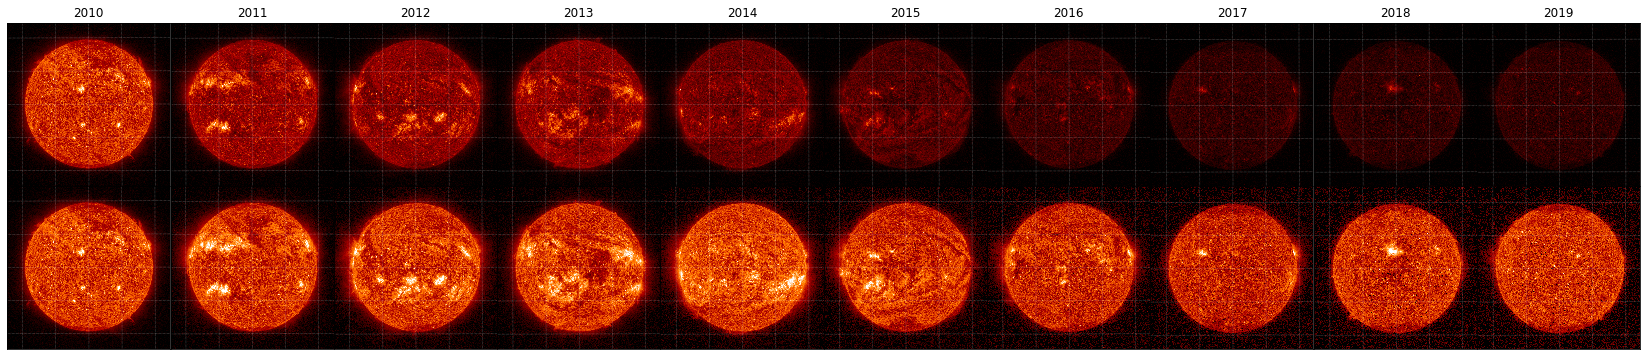

In [ ]:
# We set the image normalisation constant across the images
norm = ImageNormalize(vmin=0, vmax=1e3, stretch=LogStretch(100))

fig = plt.figure(figsize=(len(maps)*3, 6))
plt.subplots_adjust(wspace=-.2, hspace=0)

for i, (m, mc) in enumerate(zip(maps, maps_corrected)):
    ax = fig.add_subplot(2, len(maps), i+1, projection=m)
    m.plot(axes=ax, norm=norm, annotate=False)
    ax.set_title(m.date.datetime.year)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    ax.set_aspect('equal')
        
    ax = fig.add_subplot(2, len(maps), i+1+len(maps), projection=mc)
    mc.plot(axes=ax, norm=norm, annotate=False)
    ax.coords[0].set_ticks_visible(False)
    ax.coords[0].set_ticklabel_visible(False)
    ax.coords[1].set_ticks_visible(False)
    ax.coords[1].set_ticklabel_visible(False)
    ax.set_aspect('equal')

**Figure 3:** *Top*: Yearly observations of SDO/AIA 304 A data as observed by SDO/AIA, plotted on the same scale. *Bottom*: As top, but with corrected for time-dependent degradation using the AIA Autocalibration method.

---